GENERAL IMPORTS AND SEED

In [0]:
import argparse
import torch
import torchvision
from torch import optim
from torchvision import transforms
import os
import os.path as osp
import random
import numpy as np
from pathlib import Path
from torch.utils.data import dataset
import PIL
from PIL import Image

# fix the seed
seed = 1

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(seed)
random.seed(seed)

ACCESS TO THE DRIVE FOLDER WHERE THE DATASET HAS BEEN STORED

In [0]:
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/'  #change dir to your project folder

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


DEFINE ARGUMENTS

In [0]:
class Args:

    frontal_images_directories = "gdrive/My Drive/dataset-cfp/Protocol/image_list_F.txt"
    profile_images_directories = "gdrive/My Drive/dataset-cfp/Protocol/image_list_P.txt"
    split_main_directory = "gdrive/My Drive/dataset-cfp/Protocol/Split"
    split_traindata = ["01", "02", "03", "04", "05", "06"]
    split_valdata = ["07", "08"]
    split_testdata = ["09", "10"]
    dataset_root = "gdrive/My Drive"
    dataset= "CFPDataset"
    lr = float(1e-4)
    weight_decay = float(0.0005)
    momentum = float(0.9)
    betas = (0.9, 0.999)
    batch_size = int(14)
    workers = int(8)
    start_epoch = int(0)
    epochs = int(14)
    #save_every = int(2)
    pretrained = True
    #siamese_linear = True
    data_aug = True
    resume = "checkpoint_e43"


DEFINE DATASET CLASS

In [0]:

class CFPDataset(dataset.Dataset):
    def __init__(self, path, args, img_transforms=None, dataset_root="",
                 split="train", input_size=(224, 224)):
        super().__init__()

        self.data = []
        self.split = split

        self.load(path, args)

        print("Dataset loaded")
        print("{0} samples in the {1} dataset".format(len(self.data),
                                                      self.split))
        self.transforms = img_transforms
        self.dataset_root = dataset_root
        self.input_size = input_size

    def load(self, path, args):

        # read directories for frontal images
        lines = open(args.frontal_images_directories).readlines()
        idx = 0
        directories_frontal_images = []
        #print(len(lines))
        while idx < len(lines):
            x = lines[idx].strip().split()
            directories_frontal_images.append(x)
            idx += 1
        #print(x)
        # read directories for profile images
        lines = open(args.profile_images_directories).readlines()
        idx = 0
        directories_profile_images = []
        #print(len(lines))
        while idx < len(lines):
            x = lines[idx].strip().split()
            directories_profile_images.append(x)
            idx += 1
        #print(x)
        # read same and different pairs of images and save at dictionary
        self.data = []
        for i in path:
            ff_diff_file = osp.join(args.split_main_directory, 'FF', i,
                                    'diff.txt')
            lines = open(ff_diff_file).readlines()
            idx = 0
            while idx < int(len(lines)/1):
                img_pair = lines[idx].strip().split(',')
                #print('ff_diff', img_pair)
                img1_dir = directories_frontal_images[int(img_pair[0])-1][1]
                img2_dir = directories_frontal_images[int(img_pair[1])-1][1]
                pair_tag = -1
                d = {
                    "img1_path": img1_dir,
                    "img2_path": img2_dir,
                    "pair_tag": pair_tag
                }
                #print(d)
                self.data.append(d)
                idx += 1

            ff_same_file = osp.join(args.split_main_directory, 'FF', i,
                                    'same.txt')
            lines = open(ff_same_file).readlines()
            idx = 0
            while idx < int(len(lines)/1):
                img_pair = lines[idx].strip().split(',')
                #print('ff_same', img_pair)
                img1_dir = directories_frontal_images[int(img_pair[0])-1][1]
                img2_dir = directories_frontal_images[int(img_pair[1])-1][1]
                pair_tag = 1
                d = {
                    "img1_path": img1_dir,
                    "img2_path": img2_dir,
                    "pair_tag": pair_tag
                }
                #print(d)
                self.data.append(d)
                idx += 1

            fp_diff_file = osp.join(args.split_main_directory, 'FP', i,
                                    'diff.txt')
            lines = open(fp_diff_file).readlines()
            idx = 0
            while idx < int(len(lines)/1):
                img_pair = lines[idx].strip().split(',')
                #print('fp_diff', img_pair)
                img1_dir = directories_frontal_images[int(img_pair[0])-1][1]
                img2_dir = directories_profile_images[int(img_pair[1])-1][1]
                pair_tag = -1
                d = {
                    "img1_path": img1_dir,
                    "img2_path": img2_dir,
                    "pair_tag": pair_tag
                }
                #print(d)
                self.data.append(d)
                idx += 1

            fp_same_file = osp.join(args.split_main_directory, 'FP', i,
                                    'same.txt')
            lines = open(fp_same_file).readlines()
            idx = 0
            while idx < int(len(lines)/1):
                img_pair = lines[idx].strip().split(',')
                #print('ff_same', img_pair)
                img1_dir = directories_frontal_images[int(img_pair[0])-1][1]
                img2_dir = directories_profile_images[int(img_pair[1])-1][1]
                pair_tag = 1
                d = {
                    "img1_path": img1_dir,
                    "img2_path": img2_dir,
                    "pair_tag": pair_tag
                }
                #print(d)
                self.data.append(d)
                idx += 1

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        d = self.data[index]
        image1_path = osp.join(self.dataset_root, 'dataset-cfp', d[
            'img1_path'])
        image2_path = osp.join(self.dataset_root, 'dataset-cfp', d[
            'img2_path'])
        image1 = Image.open(image1_path).convert('RGB')
        image2 = Image.open(image2_path).convert('RGB')
        tag = d['pair_tag']
        if self.transforms is not None:
            # this converts from (HxWxC) to (CxHxW) as wel
            img1 = self.transforms(image1)
            img2 = self. transforms(image2)

        return img1, img2, tag

DEFINE DATA LOADER

In [0]:
from torch.utils import data

def get_dataloader(datapath, args, img_transforms=None, split="train"):

    if split == 'train':
        shuffle = True
        drop_last = True
    else:
        shuffle = False
        drop_last = False
    
    dataset = CFPDataset(datapath,
                         args,
                         split=split,
                         img_transforms=img_transforms,
                         dataset_root=osp.expanduser(args.dataset_root))
    
    data_loader = data.DataLoader(dataset,
                                  batch_size=args.batch_size,
                                  shuffle=shuffle,    
                                  num_workers=args.workers,
                                  pin_memory=True,
                                  drop_last=drop_last)
    return data_loader

DEFINE MODEL

In [0]:

import torch
from torch import nn
from torchvision.models import resnet50

def l2norm(x):
  x = x / torch.sqrt(torch.sum(x**2, dim=-1, keepdim=True))
  return x

class SiameseCosine(nn.Module):
    """
    Siamese network
    """
    def __init__(self, pretrained=False):
        super(SiameseCosine, self).__init__()

        resnet50_model = resnet50(pretrained=pretrained)
        self.feat = resnet50_model
        
    def forward(self, img1, img2):
        feat_1 = self.feat(img1)
        feat_1 = l2norm(feat_1)
        
        feat_2 = self.feat(img2)
        feat_2 = l2norm(feat_2)

      
        return feat_1, feat_2
      

DEFINE LOSS

In [0]:
from torch import nn

class RecognitionCriterion(nn.Module):
    def __init__(self):
        super().__init__()
        self.classification_criterion = nn.CosineEmbeddingLoss(margin=0.5).cuda()
        self.cls_loss = None

    def forward(self, *input):
        self.cls_loss = self.classification_criterion(*input)
        return self.cls_loss

DEFINE TRAINING AND VALIDATION FUNCTIONS

In [0]:
import torch
from torchvision import transforms
from torch.nn import functional as nnfunc
import numpy as np

def similarity (vec1, vec2):
    cos = torch.nn.CosineSimilarity(dim=1, eps=1e-8)
    cos_a = cos (vec1, vec2)  
    return cos_a
  
def accuracy(vec1, vec2, y, treshold):
    correct = 0
    total = 0

    similarity_value = similarity(vec1, vec2)
   
    for value, label in zip(similarity_value, y):
        total += 1
        if value > treshold and label == 1.0:
            correct += 1
        if value < treshold and label == -1.0:
            correct += 1
    return correct/total

def train(model, loss_fn, optimizer, dataloader, epoch, device):
    model.train()
    all_loss = []
        
    for idx, (img1, img2, prob) in enumerate(dataloader):
        img1 =  img1.to('cuda:0')
        img2 = img2.to('cuda:0')
        prob = prob.float().to('cuda:0')  #label
        
     
        out1, out2 = model(img1, img2) #inputs images to model, executes model, returns features
   
        loss = loss_fn(out1, out2, prob) #calculates loss
        loss.backward() #upgrades gradients
        all_loss.append(loss.item())
        optimizer.step()
        optimizer.zero_grad()

        if idx % 100 == 0:
            message1 = "TRAIN Epoch [{0}]: [{1}/{2}] ".format(epoch, idx,
                                                              len(dataloader))
            #message2 = "Loss: [{0:.4f}]; Accuracy: [{1}]".format(loss.item(),
            #                                                    acc)
            message2 = "Loss: [{0:.4f}]".format(loss.item())
            print(message1, message2)
        torch.cuda.empty_cache()
    return all_loss

def val(model, loss_fn, dataloader, epoch, device):
    model.eval()
    all_loss = []
    
    for idx, (img1, img2, prob) in enumerate(dataloader):
        img1 =  img1.to('cuda:0')
        img2 = img2.to('cuda:0')
        prob = prob.float().to('cuda:0')  #label
        
        out1, out2 = model(img1, img2) #inputs images to model, executes model, returns features
   
        loss = loss_fn(out1, out2, prob) #calculates loss
        all_loss.append(loss.item())
                  
        if idx % 100 == 0:
            message1 = "VAL Epoch [{0}]: [{1}/{2}] ".format(epoch, idx,
                                                              len(dataloader))
            #message2 = "Loss: [{0:.4f}]; Accuracy: [{1:.4f}]".format(loss.item(),
            #                                                    acc)
            message2 = "Loss: [{0:.4f}]".format(loss.item())
            print(message1, message2)
        torch.cuda.empty_cache()
    return all_loss
  
def val_sim_lim(model, dataloader, epoch, device):
    model.eval()

    sim_pos_min = 1
    sim_neg_max = -1
    pos_similarities = []
    neg_similarities = []
    for idx, (img1, img2, prob) in enumerate(dataloader):
        img1 =  img1.to('cuda:0')
        img2 = img2.to('cuda:0')
        prob = prob.float().to('cuda:0')  #label
             
        out1, out2 = model(img1, img2) #inputs images to model, executes model, returns features
        
        sim = similarity(out1, out2)
        for value, label in zip(sim, prob):
            value = value.item()
            np.round(value, decimals=3)
            if label == 1:
                pos_similarities.append(value)
            else:
                neg_similarities.append(value)     
                
        if idx % 100 == 0:
            message1 = "VAL Epoch [{0}]: [{1}/{2}] ".format(epoch, idx,
                                                              len(dataloader))
            print(message1)
        torch.cuda.empty_cache()
    return pos_similarities, neg_similarities
  
def val_tr(model, dataloader, epoch, device, tr):
    model.eval()
    all_loss = []
    all_acc = []  
    for idx, (img1, img2, prob) in enumerate(dataloader):
        img1 =  img1.to('cuda:0')
        img2 = img2.to('cuda:0')
        prob = prob.float().to('cuda:0')  #label
           
        out1, out2 = model(img1, img2) #inputs images to model, executes model, returns features

        acc = accuracy(out1, out2, prob, tr)
        all_acc.append(acc)

        if idx % 100 == 0:
            message1 = "VAL Epoch [{0}]: [{1}/{2}] ".format(epoch, idx,
                                                              len(dataloader))
            message2 = "Accuracy: [{0}]".format(acc)
            #message2 = "Loss: [{0:.4f}]".format(loss.item())
            print(message1, message2)
        torch.cuda.empty_cache()
    return all_acc
  
  
def test(model, loss_fn, dataloader, epoch, device, tr):
    #model = model.to(device)
    model.eval()
    all_acc = []
        
    for idx, (img1, img2, prob) in enumerate(dataloader):
        img1 =  img1.to('cuda:0')
        img2 = img2.to('cuda:0')
        prob = prob.float().to('cuda:0')  #label
        
     
        out1, out2 = model(img1, img2) #inputs images to model, executes model, returns features

        acc = accuracy(out1, out2, prob, tr)
        all_acc.append(acc)

        if idx % 100 == 0:
            message1 = "TEST Epoch [{0}]: [{1}/{2}] ".format(epoch, idx,
                                                              len(dataloader))
            message2 = "Accuracy: [{0}]".format(acc)
            #message2 = "Loss: [{0:.4f}]".format(loss.item())
            print(message1, message2)
        torch.cuda.empty_cache()
    return all_acc

LOAD ARGUMENTS AND DEFINE IMAGE TRANSFORMS

In [0]:
args = Args()

train_transform=None
if args.data_aug == False:
  img_transforms = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

else:
  img_transforms = transforms.Compose([transforms.Resize((224, 224)), 
                                        transforms.RandomHorizontalFlip(), 
                                        transforms.RandomRotation(20, resample=PIL.Image.BILINEAR), 
                                        transforms.ToTensor()])

    

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

LOAD DATASET SPLIT FOR TRAINING

In [0]:
train_loader = get_dataloader(args.split_traindata, args,
                              img_transforms=img_transforms)

Dataset loaded
8400 samples in the train dataset


LOAD DATASET SPLIT FOR VALIDATION

In [0]:
val_loader = get_dataloader(args.split_valdata, args,
                            img_transforms=val_transforms, split="val")

Dataset loaded
2800 samples in the val dataset


SPECIFY DEVICE

In [0]:
torch.cuda.is_available()

True

In [0]:
# check for CUDA
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

LOAD MODEL

In [0]:

model = SiameseCosine(pretrained=args.pretrained)

model = model.to(device) # treure de train i validation

loss_fn = RecognitionCriterion()

COUNT MODEL PARAMETERS

In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

25557032

SPECIFY WEIGHTS DIRECTORY

In [0]:
# directory where we'll store model weights
weights_dir = "gdrive/My Drive/weights"
if not osp.exists(weights_dir):
    os.mkdir(weights_dir)

SELECT OPTIMIZER

In [0]:
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr,
                             weight_decay=args.weight_decay)

#optimizer = optim.SGD(model.parameters(), lr=args.lr,
#                      momentum=args.momentum, weight_decay=args.weight_decay)

DEFINE CHECKPOINT

In [0]:
def save_checkpoint(state, filename="checkpoint.pth", save_path=weights_dir):
    # check if the save directory exists
    if not Path(save_path).exists():
        Path(save_path).mkdir()

    save_path = Path(save_path, filename)
    torch.save(state, str(save_path))

RUN TRAIN

TRAIN Epoch [0]: [0/600]  Loss: [0.4028]
TRAIN Epoch [0]: [100/600]  Loss: [0.1942]
TRAIN Epoch [0]: [200/600]  Loss: [0.1079]
TRAIN Epoch [0]: [300/600]  Loss: [0.1483]
TRAIN Epoch [0]: [400/600]  Loss: [0.1724]
TRAIN Epoch [0]: [500/600]  Loss: [0.2090]
VAL Epoch [0]: [0/200]  Loss: [0.2380]
VAL Epoch [0]: [100/200]  Loss: [0.0576]
TRAIN Epoch [1]: [0/600]  Loss: [0.1083]
TRAIN Epoch [1]: [100/600]  Loss: [0.1062]
TRAIN Epoch [1]: [200/600]  Loss: [0.1232]
TRAIN Epoch [1]: [300/600]  Loss: [0.1151]
TRAIN Epoch [1]: [400/600]  Loss: [0.1628]
TRAIN Epoch [1]: [500/600]  Loss: [0.1744]
VAL Epoch [1]: [0/200]  Loss: [0.2193]
VAL Epoch [1]: [100/200]  Loss: [0.0483]
TRAIN Epoch [2]: [0/600]  Loss: [0.1057]
TRAIN Epoch [2]: [100/600]  Loss: [0.0959]
TRAIN Epoch [2]: [200/600]  Loss: [0.1395]
TRAIN Epoch [2]: [300/600]  Loss: [0.0721]
TRAIN Epoch [2]: [400/600]  Loss: [0.1281]
TRAIN Epoch [2]: [500/600]  Loss: [0.0690]
VAL Epoch [2]: [0/200]  Loss: [0.2480]
VAL Epoch [2]: [100/200]  Loss: [

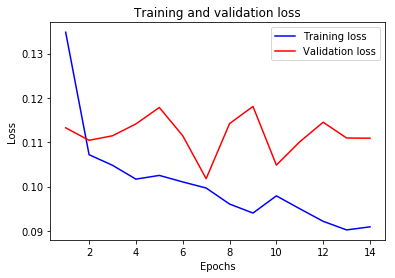

In [0]:
import matplotlib.pyplot as plt
# train and evalute for `epochs`
loss_epoch_train = []
loss_epoch_val = []
acc_epoch_train = []
acc_epoch_val = []

best_loss = 100
best_epoch = 0

for epoch in range(args.start_epoch, args.epochs):
    # scheduler.step()
    train_loss = train(model, loss_fn, optimizer, train_loader, epoch, device=device)
    
    av_loss = np.mean(train_loss)
    loss_epoch_train.append(av_loss)


    val_loss = val(model, loss_fn, val_loader, epoch, device=device)
    
    av_loss = np.mean(val_loss)
    loss_epoch_val.append(av_loss)

    if best_loss > av_loss:
        best_loss = av_loss
        best_epoch = epoch
        save_checkpoint({
            'epoch': epoch + 1,
            'batch_size': val_loader.batch_size,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict()
         }, filename=str(args.resume)+".pth",
             save_path=weights_dir)
    
print("Best Epoch: ",best_epoch, "Best Loss: ", best_loss)
    
epochs = range(1, len(loss_epoch_train) + 1)
# b is for "solid blue line"
plt.plot(epochs, loss_epoch_train, 'b', label='Training loss')
# r is for "solid red line"
plt.plot(epochs, loss_epoch_val, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#epochs = range(1, len(acc_epoch_train) + 1)
# b is for "solid blue line"
#plt.plot(epochs, acc_epoch_train, 'b', label='Training accuracy')
# r is for "solid red line"
#plt.plot(epochs, acc_epoch_val, 'r', label='Validation accuracy')
#plt.title('Training and validation accuracy')
#plt.xlabel('Epochs')
#plt.ylabel('Accuracy')
#plt.legend()
#plt.show()

LOAD STORED WEIGHTS

In [0]:
weights = osp.join(weights_dir,args.resume+'.pth')
epoch = 7
if args.resume:
    print(weights)
    checkpoint = torch.load(weights)
    model.load_state_dict(checkpoint['model'])
    #optimizer.load_state_dict(checkpoint['optimizer'])
    # Set the start epoch if it has not been
    if not args.start_epoch:
        args.start_epoch = checkpoint['epoch']

gdrive/My Drive/weights/checkpoint_e43.pth


COMPUTE SIMILARITIES AND PERCENTILS FOR THE VALIDATION SPLIT

In [0]:
import numpy as np
# View similarities

sim_pos, sim_neg = val_sim_lim(model, val_loader, epoch, device=device)
pos_95 = np.percentile(sim_pos,95)
pos_5 = np.percentile(sim_pos,5)
pos_max = np.amax(sim_pos)
pos_min = np.amin(sim_pos)
print(pos_95, pos_5, pos_max, pos_min)

neg_95 = np.percentile(sim_neg,95)
neg_5 = np.percentile(sim_neg,5)
neg_max = np.amax(sim_neg)
neg_min = np.amin(sim_neg)
print(neg_95, neg_5, neg_max, neg_min)


VAL Epoch [7]: [0/200] 
VAL Epoch [7]: [100/200] 
0.9995293229818344 0.664755803346634 0.9999874234199524 0.1921370029449463
0.9950517982244492 -0.23517231941223143 0.9998875260353088 -0.4689706265926361


SELECT THRESHOLD

In [0]:
import numpy

# Select treshold
best_acc = 0
best_tr = 0
sup = numpy.round(neg_95,decimals=3)
inf = numpy.round(pos_5,decimals=3)
#for value in range(100, 900, 100):
for value in numpy.arange(inf, sup, 0.1):
    numpy.round(value,decimals=3)
    val_acc = val_tr(model, val_loader, epoch, device=device, tr=value)
    av_acc = np.mean(val_acc)
    if av_acc > best_acc:
      best_acc = av_acc
      best_tr = value
      print('Best accuracy:', av_acc, 'Treshold:', best_tr)

sup = numpy.round(best_tr+.05,decimals=3)
inf = numpy.round(best_tr-.05,decimals=3)
for value in numpy.arange(inf, sup, 0.01):
    numpy.round(value,decimals=3)
    val_acc = val_tr(model, val_loader, epoch, device=device, tr=value)
    av_acc = np.mean(val_acc)
    if av_acc > best_acc:
      best_acc = av_acc
      best_tr = value
      print('Best accuracy:', av_acc, 'Treshold:', best_tr)

sup = numpy.round(best_tr+.005,decimals=3)
inf = numpy.round(best_tr-.005,decimals=3)
for value in numpy.arange(inf, sup, 0.001):
    numpy.round(value,decimals=3)
    val_acc = val_tr(model, val_loader, epoch, device=device, tr=value)
    av_acc = np.mean(val_acc)
    if av_acc > best_acc:
      best_acc = av_acc
      best_tr = value
      print('Best accuracy:', av_acc, 'Treshold:', best_tr)
      
print('Best accuracy:', av_acc, 'Treshold:', best_tr)

VAL Epoch [7]: [0/200]  Accuracy: [0.5]
VAL Epoch [7]: [100/200]  Accuracy: [0.9285714285714286]
Best accuracy: 0.8189285714285713 Treshold: 0.665
VAL Epoch [7]: [0/200]  Accuracy: [0.5714285714285714]
VAL Epoch [7]: [100/200]  Accuracy: [0.9285714285714286]
Best accuracy: 0.8221428571428572 Treshold: 0.765
VAL Epoch [7]: [0/200]  Accuracy: [0.5714285714285714]
VAL Epoch [7]: [100/200]  Accuracy: [0.9285714285714286]
VAL Epoch [7]: [0/200]  Accuracy: [0.7142857142857143]
VAL Epoch [7]: [100/200]  Accuracy: [1.0]
VAL Epoch [7]: [0/200]  Accuracy: [0.5714285714285714]
VAL Epoch [7]: [100/200]  Accuracy: [0.9285714285714286]
VAL Epoch [7]: [0/200]  Accuracy: [0.5714285714285714]
VAL Epoch [7]: [100/200]  Accuracy: [0.9285714285714286]
VAL Epoch [7]: [0/200]  Accuracy: [0.5714285714285714]
VAL Epoch [7]: [100/200]  Accuracy: [0.9285714285714286]
VAL Epoch [7]: [0/200]  Accuracy: [0.5714285714285714]
VAL Epoch [7]: [100/200]  Accuracy: [0.9285714285714286]
VAL Epoch [7]: [0/200]  Accuracy: 

LOAD DATASET SPLIT FOR TEST

In [0]:
test_loader = get_dataloader(args.split_testdata, args,
                             img_transforms=val_transforms, split="test")

Dataset loaded
2800 samples in the test dataset


RUN TEST

In [0]:
# Test

best_tr = 0.771
test_acc = test(model, loss_fn, test_loader, epoch, device=device, tr=best_tr)
av_acc = np.mean(test_acc)
print('Average test accuracy:', av_acc)

TEST Epoch [7]: [0/200]  Accuracy: [0.5714285714285714]
TEST Epoch [7]: [100/200]  Accuracy: [1.0]
Average test accuracy: 0.8246428571428572
